# Facial Keypoint Detection


## Initialize environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D
import os, gc

Using TensorFlow backend.
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.2.4
1.13.1


In [3]:

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

0


In [4]:
train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)

## Exploratory Data Analysis

In [5]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


Check missing values and replace NaN's with mean values in that column

In [6]:
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()
train_data[columns_nan] = train_data[columns_nan].fillna(value=train_data[columns_nan].mean())

Create training vector with images and normalize thee

In [7]:

x_train = []
for i in range(train_data.shape[0]):
    image = train_data['Image'][i].split(' ')
    image = ['0' if x == '' else x for x in image]
    x_train.append(image)
    
x_train = np.array(x_train,dtype = 'float')
x_train = x_train/255.0
x_train = x_train.reshape(-1,96,96,1)
    

Display test image.

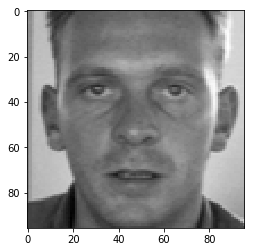

In [8]:
plt.imshow(x_train[2].reshape(96,96),cmap='gray')
plt.show()

Generate labels 

In [9]:

y_train = []
for i in range(train_data.shape[0]):
    label = train_data.iloc[i,0:30]
    y_train.append(label)
    
y_train = np.array(y_train,dtype = 'float')



In [10]:
# Define callback function if detailed log required
class History(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_acc = []
        self.val_acc = []
        self.val_loss = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_acc.append(logs.get('mae'))
        
    def on_epoch_end(self, batch, logs={}):    
        self.val_acc.append(logs.get('val_mae'))
        self.val_loss.append(logs.get('val_loss'))
        
# Implement ModelCheckPoint callback function to save CNN model
class CNN_ModelCheckpoint(tensorflow.keras.callbacks.Callback):

    def __init__(self, model, filename):
        self.filename = filename
        self.cnn_model = model

    def on_train_begin(self, logs={}):
        self.max_val_acc = 0
        
 
    def on_epoch_end(self, batch, logs={}):    
        val_acc = logs.get('val_mae')
        if(val_acc > self.max_val_acc):
           self.max_val_acc = val_acc
           self.cnn_model.save(self.filename)

In [11]:
def base_model():
    model_input = Input(shape=(96,96,1))

    x = Convolution2D(32, (3,3), padding='same', use_bias=False)(model_input)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(64, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(96, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(128, (3,3),padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(256, (3,3),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Convolution2D(512, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.2)(x)
    model_output = Dense(30)(x)
    model = Model(model_input, model_output, name="base_model")
    return model

model = base_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)    

In [12]:
from tensorflow.keras.optimizers import Nadam
#from tensorflow.keras.optimizers.schedules import InverseTimeDecay

optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)



model.compile(optimizer= optimizer, 
              loss='mean_squared_error',
              metrics=['mae'])

Instructions for updating:
Use tf.cast instead.


Run for 500 epochs and keeping 20% train-valid split

In [13]:
model.fit(x_train,y_train,epochs = 500,batch_size = 256,validation_split = 0.2)

Train on 5639 samples, validate on 1410 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
5639/5639 [==============================] - 7s 1ms/sample - loss: 2548.7262 - mean_absolute_error: 46.8811 - val_loss: 2636.3993 - val_mean_absolute_error: 47.8831
Epoch 2/500
5639/5639 [==============================] - 3s 568us/sample - loss: 2320.7477 - mean_absolute_error: 44.5805 - val_loss: 2633.8620 - val_mean_absolute_error: 47.8589
Epoch 3/500
5639/5639 [==============================] - 3s 572us/sample - loss: 2023.4630 - mean_absolute_error: 41.3607 - val_loss: 2629.0905 - val_mean_absolute_error: 47.8132
Epoch 4/500
5639/5639 [==============================] - 4s 633us/sample - loss: 1694.7758 - mean_absolute_error: 37.4888 - val_loss: 2618.5417 - val_mean_absolute_error: 47.7137
Epoch 5/500
5639/5639 [==============================] - 3s 584us/sample - loss: 1380.1990 - mean_absolute_error: 33.3675 - val_loss: 2595.5097 - val_mean_absolute_error: 47.4949
Epoch 6/500